# Box Concatenate Test

This notebook is to test concatentating lots of separate netcdf files into one netcdf or zarr file. I will test the functionality using the smaller scale tests located in `/swot/SUM05/amf2288/sync-boxes/test_boxes`. This was entirely written by chatGPT, I should comb through it later to make sure I understand what's going on. Also it could probably be written a little simpler.

In [11]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import argopy
import scipy.ndimage as filter
import scipy
import matplotlib
import gsw
from pathlib import Path
import cartopy.crs as ccrs
import os

import dask
from dask.diagnostics import ProgressBar

In [12]:
def concatenate_netcdf(input_dir: str, first_dim: str, second_dim: str, output_dir: str, output_file: str):
    input_path = Path(input_dir)
    netcdf_files = list(input_path.glob("*.nc"))
    
    # Create the output directory if it doesn't exist
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Open datasets lazily with dask
    datasets = [xr.open_dataset(str(file), chunks={}) for file in netcdf_files]
    
    # Concatenate along the first dimension
    combined_first_dim = xr.concat(datasets, dim=first_dim)
    
    # Rechunk the data to ensure uniform chunk sizes
    combined_rechunked = combined_first_dim.chunk({first_dim: 256, second_dim: 256})  # Adjust chunk sizes as needed
    
    # Save to NetCDF
    output_file_path = output_path / output_file
    with ProgressBar():
        combined_rechunked.to_netcdf(output_file_path, compute=True)

def concatenate_zarr(input_dir: str, first_dim: str, second_dim: str, output_dir: str, output_file: str):
    input_path = Path(input_dir)
    netcdf_files = list(input_path.glob("*.nc"))
    
    # Create the output directory if it doesn't exist
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Open datasets lazily with dask
    datasets = [xr.open_dataset(str(file), chunks={}) for file in netcdf_files]
    
    # Concatenate along the first dimension
    combined_first_dim = xr.concat(datasets, dim=first_dim)
    
    # Rechunk the data to ensure uniform chunk sizes
    combined_rechunked = combined_first_dim.chunk({first_dim: 256, second_dim: 256})  # Adjust chunk sizes as needed
    
    # Save to Zarr
    output_file_path = output_path / output_file
    with ProgressBar():
        combined_rechunked.to_zarr(output_file_path, compute=True)

In [14]:
# Example usage
input_directory = "/swot/SUM05/amf2288/sync-boxes/retry"
output_directory = "/swot/SUM05/amf2288/sync-boxes"
output_netcdf = "retry.nc"
output_zarr = "test_error.zarr"
first_dim = "N_PROF"
second_dim = "PRES_INTERPOLATED"

In [15]:
# Concatenate along both dimensions and save to NetCDF
concatenate_netcdf(input_directory, first_dim, second_dim, output_directory, output_netcdf)

[########################################] | 100% Completed | 63.91 s


In [16]:
# Concatenate along both dimensions and save to Zarr
#concatenate_zarr(input_directory, first_dim, second_dim, output_directory, output_zarr)

In [17]:
ds = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/retry.nc')

In [18]:
ds

<xarray.Dataset> Size: 3GB
Dimensions:            (N_PROF: 64543, PRES_INTERPOLATED: 1000)
Coordinates:
    TIME               (N_PROF) datetime64[ns] 516kB ...
    LATITUDE           (N_PROF) float64 516kB ...
    LONGITUDE          (N_PROF) float64 516kB ...
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 8kB 0 2 4 6 ... 1994 1996 1998
  * N_PROF             (N_PROF) int64 516kB 142 170 199 201 ... 759 760 761 762
    N_PROF_NEW         (N_PROF) int64 516kB ...
Data variables:
    CT                 (N_PROF, PRES_INTERPOLATED) float64 516MB ...
    CYCLE_NUMBER       (N_PROF) int64 516kB ...
    DATA_MODE          (N_PROF) <U1 258kB ...
    DIRECTION          (N_PROF) <U1 258kB ...
    PLATFORM_NUMBER    (N_PROF) int64 516kB ...
    PRES               (N_PROF, PRES_INTERPOLATED) float32 258MB ...
    PSAL               (N_PROF, PRES_INTERPOLATED) float32 258MB ...
    SA                 (N_PROF, PRES_INTERPOLATED) float64 516MB ...
    SIG0               (N_PROF, PRES_INTERPOLATED) float64 516MB ...
    TEMP               (N_PROF, PRES_INTERPOLATED) float32 258MB ...
    sample_rate        (N_PROF, PRES_INTERPOLATED) float32 258MB ...
    SPICE              (N_PROF, PRES_INTERPOLATED) float64 516MB ...
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_by:           amf2288
    Fetched_date:         2025/02/19
    Fetched_constraints:  [x=-110.00/-105.00; y=5.00/10.00; z=0.0/2000.0]
    Fetched_uri:          https://data-argo.ifremer.fr/dac/aoml/4900313/49003...
    Valid uris:           ['https://data-argo.ifremer.fr/dac/aoml/4900313/490...
    All uris:             ['https://data-argo.ifremer.fr/dac/aoml/4900313/490...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

In [19]:
#xr.open_zarr('/swot/SUM05/amf2288/sync-boxes/test_concat/test_out.zarr')

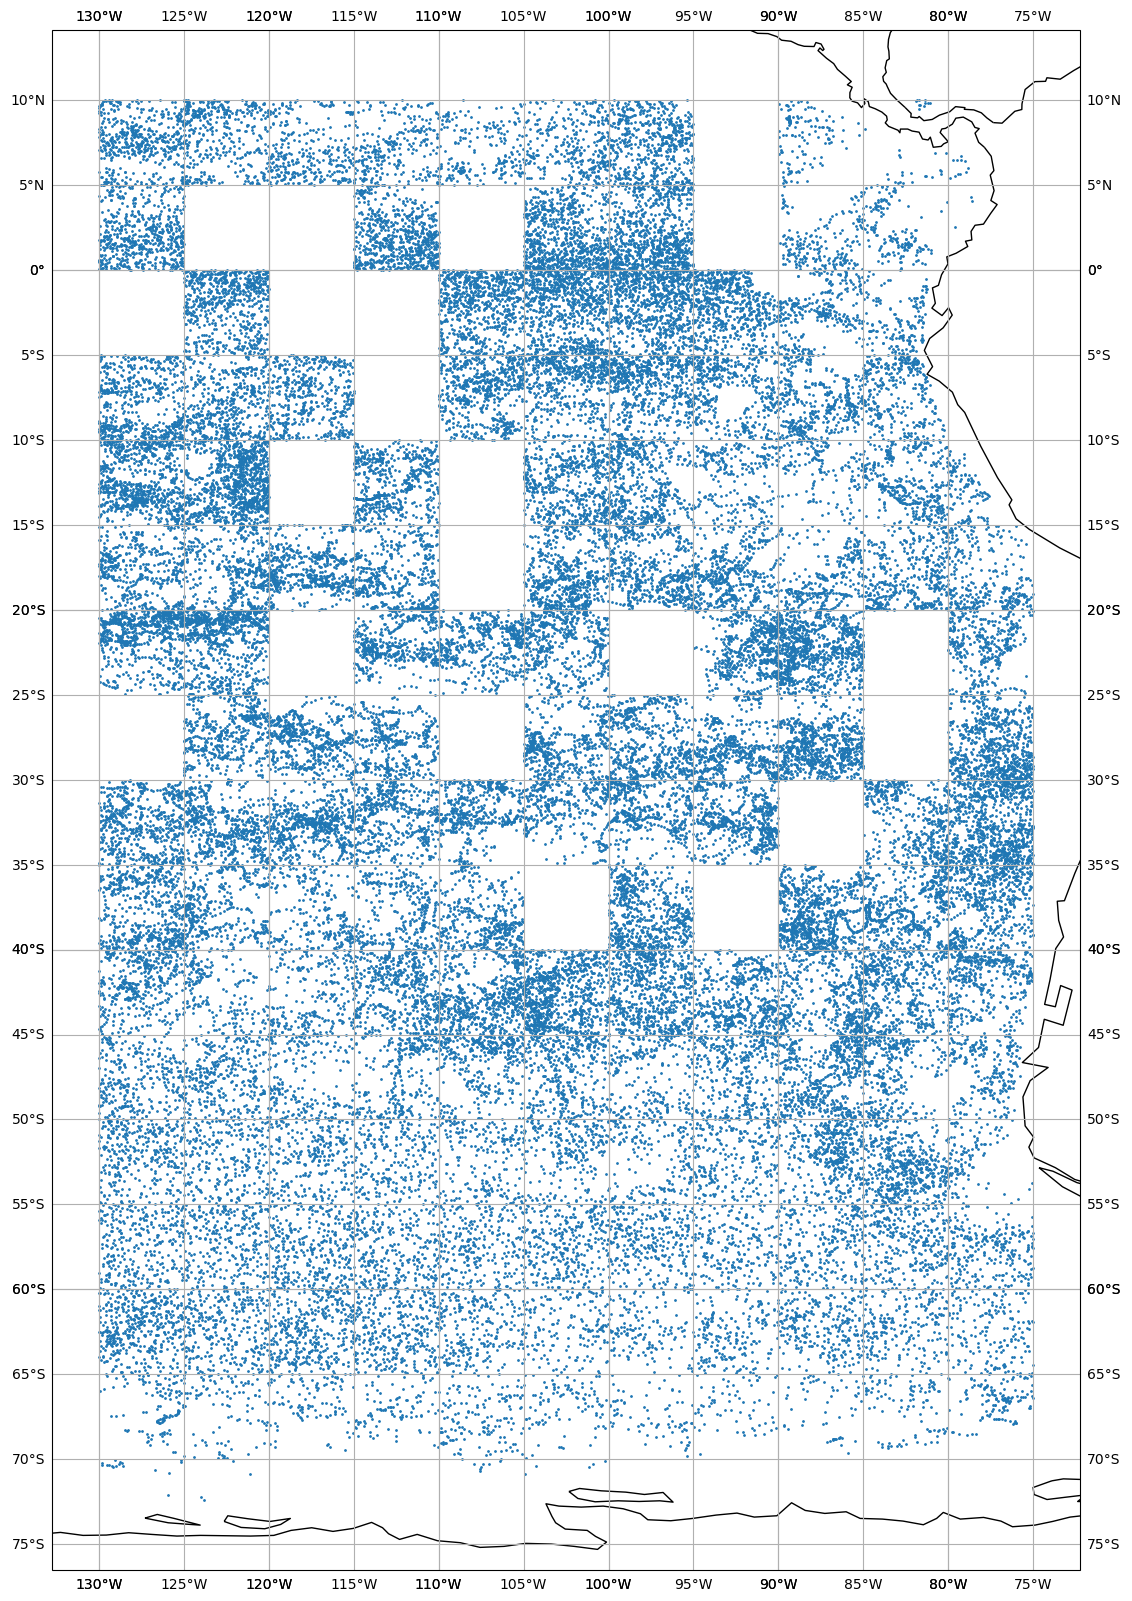

In [20]:
fig = plt.figure(figsize=(15, 20))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.scatter(ds.LONGITUDE,ds.LATITUDE,transform=ccrs.PlateCarree(),color='tab:blue',s=1)
ax.gridlines(xlocs=np.arange(-180,180,5), ylocs=np.arange(-90,90,5), draw_labels=True)

In [21]:
# Initialize the total count
valid_count = 0
all_count = 0
prof_count = 0

# Iterate over all NetCDF files in the directory
for filename in os.listdir(input_directory):
    if filename.endswith('.nc'):
        file_path = os.path.join(input_directory, filename)
        # Open the NetCDF file
        ds = xr.open_dataset(file_path)
        # Calculate the metric
        valid_uris = len(np.unique(ds.attrs['Valid uris']))
        all_uris = len(np.unique(ds.attrs['All uris']))
        prof_num = len(ds.N_PROF)
        # Increase the total count by the metric value
        valid_count += valid_uris
        all_count += all_uris
        prof_count += prof_num

In [22]:
print("TOTAL number of profiles: {}".format(all_count))
print("Number of VALID profiles: {}".format(valid_count))
print("Number of INVALID profiles: {}".format(all_count - valid_count))
print("Percent of INVALID profiles: {}".format(((all_count - valid_count)/all_count)*100))

print("Number of N_PROF: {}".format(prof_count))

TOTAL number of profiles: 12915
Number of VALID profiles: 12914
Number of INVALID profiles: 1
Percent of INVALID profiles: 0.007742934572202865
Number of N_PROF: 64543


In [13]:
test = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/test_error/lon:(-35,-30)_lat:(-5,0)_ds_z.nc')

In [52]:
len(np.unique(test.attrs['Valid uris']))

118

In [50]:
len(np.unique(test.attrs['All uris']))

125

In [18]:
test

<xarray.Dataset> Size: 22MB
Dimensions:            (N_PROF: 462, PRES_INTERPOLATED: 1000)
Coordinates:
    TIME               (N_PROF) datetime64[ns] 4kB ...
    LATITUDE           (N_PROF) float64 4kB ...
    LONGITUDE          (N_PROF) float64 4kB ...
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 8kB 0 2 4 6 ... 1994 1996 1998
  * N_PROF             (N_PROF) int64 4kB 97 103 116 122 ... 1119 700 1150 1120
    N_PROF_NEW         (N_PROF) int64 4kB ...
Data variables:
    CT                 (N_PROF, PRES_INTERPOLATED) float64 4MB ...
    CYCLE_NUMBER       (N_PROF) int64 4kB ...
    DATA_MODE          (N_PROF) <U1 2kB ...
    DIRECTION          (N_PROF) <U1 2kB ...
    PLATFORM_NUMBER    (N_PROF) int64 4kB 39038 39038 39038 ... 4903371 3902236
    PRES               (N_PROF, PRES_INTERPOLATED) float32 2MB ...
    PSAL               (N_PROF, PRES_INTERPOLATED) float32 2MB ...
    SA                 (N_PROF, PRES_INTERPOLATED) float64 4MB ...
    SIG0               (N_PROF, PRES_INTERPOLATED) float64 4MB ...
    TEMP               (N_PROF, PRES_INTERPOLATED) float32 2MB ...
    sample_rate        (N_PROF, PRES_INTERPOLATED) float32 2MB ...
    SPICE              (N_PROF, PRES_INTERPOLATED) float64 4MB ...
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_by:           amf2288
    Fetched_date:         2025/02/10
    Fetched_constraints:  [x=-35.00/-30.00; y=-5.00/0.00; z=0.0/2000.0]
    Fetched_uri:          https://data-argo.ifremer.fr/dac/bodc/3900560/39005...
    Valid uris:           ['https://data-argo.ifremer.fr/dac/bodc/3900560/390...
    All uris:             ['https://data-argo.ifremer.fr/dac/bodc/3900560/390...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...